<a href="https://colab.research.google.com/github/elisabethelen/T2_DeepLearning/blob/main/202255202026_T2_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Task Klasifikasi Gambar
Menggunakan objek Piring dengan 4 kelas diantaranya Piring Kaca, Piring Plastik, Piring Melamin, Piring Keramik**

***Mount Google Drive***

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***Import Necessary Libraries***

In [2]:
# Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid

In [3]:
# Cek device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [4]:
# Path ke dataset
data_path = "/content/drive/MyDrive/dataset"

***Load and Transform Data***

In [5]:
# ================= 3. Load and Transform Data =================
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [7]:
# ================= 4. Split Dataset =================
# Ganti path berikut ke lokasi folder dataset Anda
# root_dir = '/content/drive/MyDrive/dataset' # original
root_dir = '/content/drive/MyDrive/dataset'  # Assuming dataset is directly under MyDrive
data_dir = root_dir  # Update data_dir to the correct root directory

# Tetapkan seed untuk reproduksibilitas
seed = 42  # Anda dapat menggunakan nilai seed lain yang diinginkan

# ================= 4. Split Dataset =================
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
class_names = full_dataset.classes
n_total = len(full_dataset)
n_train = int(0.6 * n_total)
n_val = int(0.2 * n_total)
n_test = n_total - n_train - n_val

train_set, val_set, test_set = random_split(full_dataset, [n_train, n_val, n_test],
                                            generator=torch.Generator().manual_seed(seed))

# Ganti transform untuk val dan test
val_set.dataset.transform = test_transform
test_set.dataset.transform = test_transform

# Dataloader
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

***Placing Data into a Dataframe***

In [8]:
import pandas as pd

# Ambil list semua file dan label dari ImageFolder
image_paths = [s[0] for s in full_dataset.samples]
labels = [class_names[s[1]] for s in full_dataset.samples]

# Buat DataFrame
df = pd.DataFrame({
    'filename': image_paths,
    'label': labels
})

# Tampilkan 5 baris pertama
print(df.head())

                                            filename label
0  /content/drive/MyDrive/dataset/kaca/IMG2025041...  kaca
1  /content/drive/MyDrive/dataset/kaca/IMG2025041...  kaca
2  /content/drive/MyDrive/dataset/kaca/IMG2025041...  kaca
3  /content/drive/MyDrive/dataset/kaca/IMG2025041...  kaca
4  /content/drive/MyDrive/dataset/kaca/IMG2025041...  kaca


***Visualizing images from the dataset***

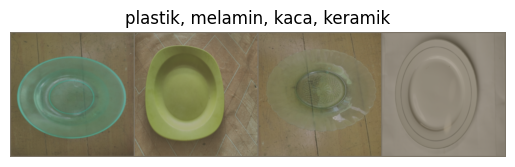

In [9]:
# Tampilkan sample gambar

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid

# Fungsi untuk menampilkan gambar
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Ambil satu gambar dari masing-masing kelas
def get_one_sample_per_class(dataloader, class_names):
    samples = {}
    for images, labels in dataloader:
        for img, lbl in zip(images, labels):
            class_name = class_names[lbl.item()]
            if class_name not in samples:
                samples[class_name] = (img, class_name)
            if len(samples) == len(class_names):
                break
        if len(samples) == len(class_names):
            break
    return samples

# Contoh penggunaan:
samples = get_one_sample_per_class(train_loader, class_names)

# Siapkan gambar dan label
images = [img for img, _ in samples.values()]
titles = [lbl for _, lbl in samples.values()]

# Buat grid dan tampilkan
imshow(make_grid(images), title=", ".join(titles))

***Model Preparation dan Modifikasi***

In [10]:
# Load model ResNet18 dan modifikasi classifier
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # freeze pretrained layers

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 140MB/s]


In [11]:
# Custom classifier
# Get the number of features from the last layer before your custom classifier
# Since model.fc is a Linear object, access in_features directly
num_ftrs = model.fc.in_features
# Assuming you have 5 classes instead of 4 based on the error message
num_classes = len(class_names)  # Get the actual number of classes from your dataset
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_ftrs, num_classes)  # Update the output layer to match the number of classes
)
model = model.to(device)

In [12]:
# Loss dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

***Training the model***

In [ ]:
# Training model
epochs = 50
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = correct / total
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/50 | Train Loss: 0.9995 | Val Loss: 0.4520 | Val Acc: 0.9208
Epoch 2/50 | Train Loss: 0.3985 | Val Loss: 0.2095 | Val Acc: 0.9875


***Visualizing loss curves***

In [ ]:
# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Train & Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

***Making predictions on the Test Data***

In [ ]:
# Evaluasi Test
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_acc = correct / total
print(f"Test Accuracy: {test_acc*100:.2f}%")

***Model Evaluation***

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

***Computing Error Rate Analysis***

In [ ]:
# Error Rate Analysis
test_error_rate = 1 - test_acc
print(f"Test Error Rate: {test_error_rate*100:.2f}%")

***Grad-Cam Visualization***

In [ ]:
# ====== 13. Grad-CAM Hooks ======
features_blobs = []
gradients = []

def hook_feature(module, input, output):
    features_blobs.append(output)

def hook_gradient(module, grad_in, grad_out):
    gradients.append(grad_out[0])

# ====== Pasang Hook pada Layer Terakhir Convolution ======
final_conv = model.layer4[1].conv2
final_conv.register_forward_hook(hook_feature)
final_conv.register_backward_hook(hook_gradient)

# ====== Fungsi Generate Grad-CAM ======
import numpy as np
import cv2

def generate_gradcam(input_tensor, class_idx=None):
    model.eval()
    features_blobs.clear()
    gradients.clear()

    output = model(input_tensor)

    if class_idx is None:
        class_idx = torch.argmax(output).item()

    model.zero_grad()
    class_score = output[0, class_idx]
    class_score.backward()

    grads_val = gradients[0].cpu().data.numpy()
    fmap = features_blobs[0].cpu().data.numpy()

    weights = np.mean(grads_val, axis=(2, 3))[0, :]

    cam = np.zeros(fmap.shape[2:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmap[0, i, :, :]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam -= np.min(cam)
    cam /= np.max(cam)
    return cam

# ====== Fungsi Visualisasi Grad-CAM ======
import matplotlib.pyplot as plt

def show_gradcam(image_tensor, cam, title='Grad-CAM'):
    image_np = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    image_np = (image_np * 0.5) + 0.5  # denormalisasi

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + image_np
    overlay = overlay / np.max(overlay)

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(title)
    plt.show()

# ====== Contoh Pemakaian Grad-CAM dari Test Loader ======
dataiter = iter(test_loader)
images, labels = next(dataiter)

input_img = images[0].unsqueeze(0).to(device)
label = labels[0].item()

cam = generate_gradcam(input_img)
show_gradcam(images[0], cam, title=f"Grad-CAM (Label: {label})")

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.gradients = None
        self.activations = None
        self.target_layer = target_layer
        self.hook()

    def hook(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, class_idx=None):
        input_tensor = input_tensor.unsqueeze(0).to(device)
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output)
        self.model.zero_grad()
        output[0, class_idx].backward()
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).squeeze()
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()
        return cam.cpu().numpy()

def show_gradcam(image_tensor, cam, alpha=0.5):
    image = image_tensor.permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (224, 224))
    overlay = heatmap * alpha + image * 255
    plt.imshow(overlay.astype(np.uint8))
    plt.axis('off')
    plt.title("Grad-CAM Result")
    plt.show()

# Contoh Grad-CAM
sample_imgs, _ = next(iter(test_loader))
sample_img = sample_imgs[0].to(device)
resnet_layer = model.layer4[1].conv2
gradcam = GradCAM(model, resnet_layer)
cam = gradcam.generate_cam(sample_img)
show_gradcam(sample_imgs[0], cam)